EX1


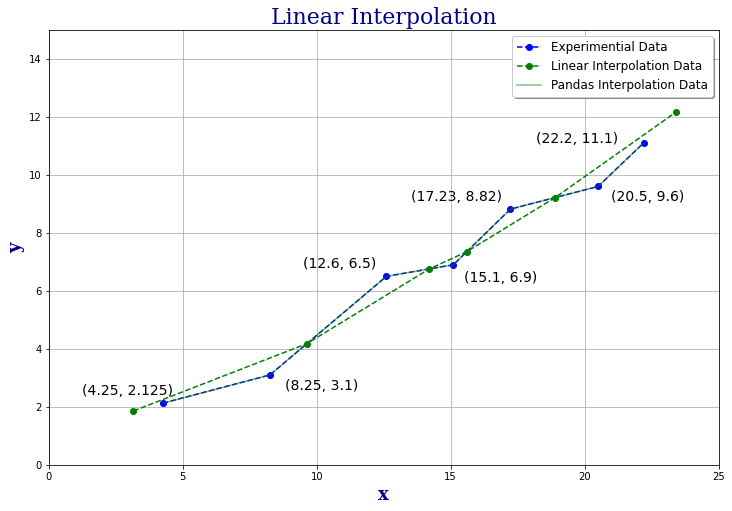

In [26]:
print("EX1")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy import interpolate
import pandas as pd


# The end points can be mirrored for calculating distance 
# between for the linear approximation.
x = np.array([4.25, 8.25, 12.6, 15.1, 17.23, 20.5, 22.2])
y = np.array([ 2.125,  3.1,  6.5,  6.9, 8.82, 9.6, 11.1])
df_lin_inter = pd.DataFrame({'dx':x, 'dy':y})
df_lin_inter.interpolate(method='linear', limit_direction='forward', inplace=True)

# Create data points halfway between each given point
def between_points(x, y):
    X = []
    for i in range(1, len(x)):
        X_ = np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2)
        X_ = X_/2 + x[i-1]
        X.append(X_)
    return X


def my_lin_interp(x, y, X):
    Y = []
    for i in range(1, len(x)):
        Y_new = y[i-1] + (y[i] - y[i-1])*(X[i-1] - x[i-1])/(x[i] - x[i-1])
        Y.append(Y_new)
    return Y


# Random set of points
X = [3.15, 9.63, 14.2, 15.6, 18.9, 23.4]
# X = between_points(x, y)  # This can be use to find best fit line
Y = my_lin_interp(x, y, X)

# Delete the two mirored end points
# index = [0, 6]
# x = np.delete(x, index)
# y = np.delete(y, index)

# Map fonts used in plot
font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 22,
        }

font2 = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'bold',
        'size': 18,
        }


plt.figure(figsize = (12, 8))
plt.plot(x, y, 'bo--', label="Experimential Data")
plt.plot(X, Y, 'go--', label="Linear Interpolation Data")
plt.plot(df_lin_inter["dx"], df_lin_inter["dy"], color='green', alpha=0.5, label="Pandas Interpolation Data")
plt.title('Linear Interpolation', fontdict=font)
plt.annotate(f'({x[0]}, {y[0]})', xy=(x[0], y[0]), xytext=(1.25, 2.4), fontsize=14)
plt.annotate('(8.25, 3.1)', xy=(8.25, 3.1), xytext=(8.8, 2.6), fontsize=14)
plt.annotate('(12.6, 6.5)', xy=(12.6, 6.5), xytext=(9.5, 6.8), fontsize=14)
plt.annotate('(15.1, 6.9)', xy=(15.1, 6.9), xytext=(15.5, 6.3), fontsize=14)
plt.annotate('(17.23, 8.82)', xy=(17.23, 8.82), xytext=(13.5, 9.1), fontsize=14)
plt.annotate('(20.5, 9.6)', xy=(20.5, 9.6), xytext=(21.0, 9.1), fontsize=14)
plt.annotate('(22.2, 11.1)', xy=(22.2, 11.1), xytext=(18.2, 11.1), fontsize=14)
plt.grid()
plt.xlim(0, 25)
plt.ylim(0, 15)
plt.xlabel('x', fontdict=font2)
plt.ylabel('y', fontdict=font2)
legend = plt.legend(loc='upper right', shadow=True, fontsize=12, fancybox=True)
plt.show()

In [ ]:
print("EX2")

def my_cubic_interp1d(x0, x, y):
    """
    Interpolate a 1-D function using cubic splines.
      x0 : a float or an 1d-array
      x : (N,) array_like
          A 1-D array of real/complex values.
      y : (N,) array_like
          A 1-D array of real values. The length of y along the
          interpolation axis must be equal to the length of x.

    Implement a trick to generate at first step the cholesky matrix L of
    the tridiagonal matrice A (thus L is a bidiagonal matrice that
    can be solved in two distinct loops). No end point conditions
    
    All x values must be intergers for this method to work.

    additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf
    https://stackoverflow.com/questions/31543775/
    how-to-perform-cubic-spline-interpolation-in-python
    """
    
    x = np.asfarray(x)
    y = np.asfarray(y)

    # remove non finite values
    indexes = np.isfinite(x)
    x = x[indexes]
    y = y[indexes]

    # check if sorted
    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]
 
    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    # allocate buffer matrices
    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = np.sqrt(2 * xdiff[0])
    Li_1[0] = 0.0
    
    B0 = 0.0  # natural boundary
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = np.sqrt(2 * (xdiff[i-1] + xdiff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(ydiff[i] / xdiff[i] - ydiff[i-1] / xdiff[i-1])
        z[i] = (Bi - Li_1[i-1] * z[i-1]) / Li[i]
    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = np.sqrt(2*xdiff[-1] - Li_1[i-1] * Li_1[i-1])
    
    Bi = 1.0  # natural boundary
    z[i] = (Bi - Li_1[i-1] * z[i-1]) / Li[i]

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1] * z[i+1]) / Li[i]

    # find index
    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]

    yi1, yi0 = y[index], y[index-1]

    zi1, zi0 = z[index], z[index-1]

    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0


x = [0.0, 0.4, 0.8, 1.2, 2.0, 2.4, 5.6, 6.4]
y = [1.5, 1.8, 2.3, 2.8, 3.8, 3.2, 2.5, 8.8]

new_x = np.linspace(x[0], x[-1], 50)
new_y = my_cubic_interp1d(new_x, x, y)

plt.figure(figsize = (10,8))
plt.plot(new_x, new_y, 'gx--', label="Cubic Spline")
plt.plot(x, y, 'bo', label=f"{len(x)} points")
plt.title(f'Cholesky Matrix L - Cubic Spline Interpolation\n'
          ' (with no endpoint conditions)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print(
""" 
The function above my_cubic_interp1d uses cholesky matrix L.
The modifications used in this method does not work well for
float type numbers. When using float type number there needs
to be a large number data point to draw through as this method
used here has no end point corrections. Works well for most 
integers.
additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf
    https://stackoverflow.com/questions/31543775/
    how-to-perform-cubic-spline-interpolation-in-python
""")

In [ ]:


def my_cubic_spline(x, y, X):
    """
    This is for four nodes (points) only x and y are the node and 
    X is the number of points to draw between the lines and must be
    in equal distances such that the distance between x1 and x2 is
    1 and the distance beween x2 and x3 is 3 then the points should
    be 3 times the number between x1 and x2.
    """
    n = len(x)
    # for four points only need to add to m equations or remove
    # some respectively depending on the number of points.
    num_equ = 4 * (n - 1)
    
    # Constraints Si(xi) = y(i)
    m1 = [x[0]**3, x[0]**2, x[0], 1, 0, 0, 0, 0, 0, 0, 0, 0]
    m2 = [0, 0, 0, 0, x[1]**3, x[1]**2, x[1], 1, 0, 0, 0, 0]
    m3 = [0, 0, 0, 0, 0, 0, 0, 0, x[2]**3, x[2]**2, x[2], 1]
    # Constraints Si(xi+1) = y(i+1)
    m4 = [x[1]**3, x[1]**2, x[1], 1, 0, 0, 0, 0, 0, 0, 0, 0]
    m5 = [0, 0, 0, 0, x[2]**3, x[2]**2, x[2], 1, 0, 0, 0, 0]
    m6 = [0, 0, 0, 0, 0, 0, 0, 0, x[3]**3, x[3]**2, x[3], 1]
    # First derivative S'(xi+1) = S'i+1(xi+1)
    m7 = [3*x[1]**2, 2*x[1], 1, 0, -3*x[1]**2, -2*x[1], -1, 0, 0, 0, 0, 0]
    m8 = [0, 0, 0, 0, 3*x[2]**2, 2*x[2], 1, 0, -3*x[2]**2, -2*x[2], -1, 0]
    m9 = [6*x[0], 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # Endpoint Conditions
    # Second derivative S''(xi+1) = S''i+1(xi+1)
    m10 = [6*x[1], 2, 0, 0, -6*x[1], -2, 0, 0, 0, 0, 0, 0]
    m11 = [0, 0, 0, 0, 6*x[2], 2, 0, 0, -6*x[2], -2, 0, 0]
    m12 = [0, 0, 0, 0, 0, 0, 0, 0, 6*x[3], 2, 0, 0]
    m = [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12]

    # Create an empty matrix annd assign values to each point.
    M = np.zeros((num_equ, num_equ))
    for i in range(len(m)):
        M[i, :] = m[i]
    
    # This is the Y vector Ax=Y
    Y = [y[0], y[1], y[2], y[1], y[2], y[3], 0, 0, 0, 0, 0, 0]

    # Solve the sytem of equations
    coef = np.dot(np.linalg.inv(M), Y)
    # To get the spacing correct used differance between x values 
    # times 50 this give proper spacing to plot
    xdiff = np.diff(x)
    x_diff_sum = np.sum(np.diff(x))
    plot_points = (25 * x_diff_sum)
   
    # Create the ranges for x values
    x_sp1 = np.arange(0, x[1], xdiff[0]/(xdiff[0]/x_diff_sum*plot_points))
    x_sp2 = np.arange(x[1], x[2], xdiff[1]/(xdiff[1]/x_diff_sum*plot_points))
    x_sp3 = np.arange(x[2], x[3]+ (xdiff[2]/(xdiff[2]/x_diff_sum*plot_points)),
                      (xdiff[2]/(xdiff[2]/x_diff_sum*plot_points)))
    
    # The equations for interpolated y value between nodes
    y_sp3 = coef[8]*x_sp3**3 + coef[9]*x_sp3**2 +  coef[10]*x_sp3 + coef[11]
    y_sp2 = coef[4]*x_sp2**3 + coef[5]*x_sp2**2 +  coef[6]*x_sp2 + coef[7]
    y_sp1 = coef[0]*x_sp1**3 + coef[1]*x_sp1**2 +  coef[2]*x_sp1 + coef[3]

    # Put them all togather
    Y = np.concatenate((y_sp1, y_sp2, y_sp3))

    return Y


x = [0, 1.4, 5.6, 6.4]
y = [1.5, 3.2, 2.5, 8.8]
x_diff_sum = (np.sum(25*np.diff(x)))
x_sp = np.arange(0, np.max(x) + (np.max(x)/x_diff_sum), (np.max(x)/x_diff_sum))
y_sp = my_cubic_spline(x, y, x_sp)

fig = plt.figure(figsize = (10,8))
plt.plot(x, y, 'bo', label=f"{len(x)} points")
plt.plot(x_sp, y_sp, 'g.--', alpha=0.4, label="Cubic Spline")
plt.title(f'Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("""
There is a better way to do this using a Jacobi Matrix,
Lagrangian Cubic Spline, or a cholesky matrix L.
None of those are coved in this book, not much of anything
concerning development of a interpolation outside of linear
is covered. I tried to use a loop to write this and had issues
with derivatives S'(xi=1) and S''(xi+1), including the end
conditions, where S'(xi=1) = S''(xi+1) = 0.0.
""")

First 11 Values
    x_values  y_values
0   0.000000  1.500000
1   0.130612  1.962310
2   0.261224  2.350859
3   0.391837  2.669522
4   0.522449  2.922174
5   0.653061  3.112689
6   0.783673  3.244943
7   0.914286  3.322810
8   1.044898  3.350165
9   1.175510  3.330883
10  1.306122  3.268839


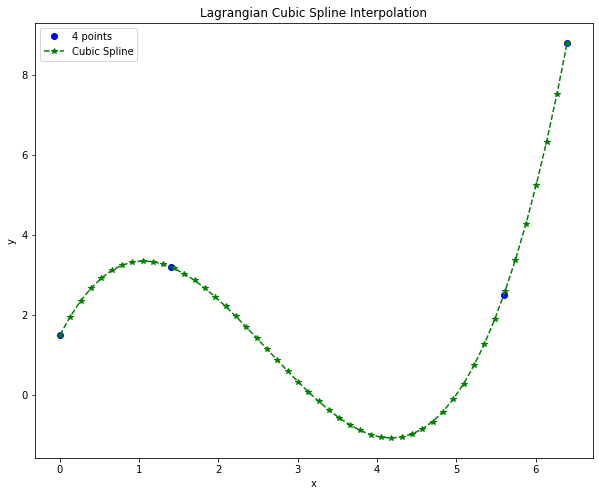


The Lagrangian Cubic Spline Interpolation works well
for most number combinations.


In [24]:


def Lagrangian_cubic_spline(x, y, xp):
    """
    This is the Lagrangian cubic spline method input
    x values (x) , y values (y), and predicted x values (xp).
    Output is the list of predicted y values."""
    # Set interpolated value initially to zero
    n = len(x)
    yp = 0
    # Lagrange Interpolation Method
    for i in range(n):
        p = 1
        for j in range(n):
            if i != j:  # prevent divide by zero
                p = p * (xp - x[j])/(x[i] - x[j])
        yp = yp + p * y[i]
    # print(f'y values\n{yp}')
    return yp

# Number of data points
x = [0, 1.4, 5.6, 6.4]
y = [1.5, 3.2, 2.5, 8.8]

xp = np.linspace(0, x[-1], 50)
# print(f'x values\n{xp}')
yp = Lagrangian_cubic_spline(x, y, xp)
df = pd.DataFrame(list(zip(xp, yp)),
               columns =['x_values', 'y_values'])
print('First 11 Values')
print(df[:11])
fig = plt.figure(figsize = (10,8))
plt.plot(x, y, 'bo', label=f"{len(x)} points")
plt.plot(xp, yp, 'g*--', label="Cubic Spline")
plt.title(f'Lagrangian Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("""
The Lagrangian Cubic Spline Interpolation works well
for most number combinations.""")

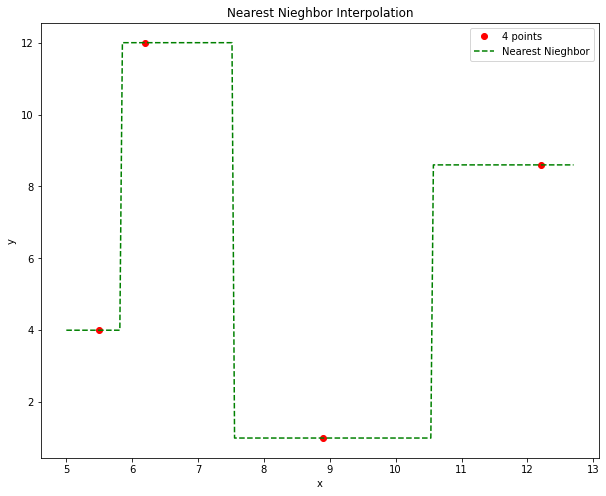

In [13]:
def my_nearest_neighbor(x, y, X):
    
    idx = np.abs(x - X[:, None])
    return y[idx.argmin(axis=1)]

x = np.array([5.5, 6.2, 8.9, 12.2])
y = np.array([4, 12, 1, 8.6])
offset = 0.5
xi = np.linspace((np.min(x) - offset), (np.max(x) + offset), 200)
yi = my_nearest_neighbor(x, y, xi)

fig = plt.figure(figsize = (10,8))
plt.plot(x, y, 'ro', label=f"{len(x)} points")
plt.plot(xi, yi, 'g--', label="Nearest Nieghbor")
plt.title(f"Nearest Nieghbor Interpolation")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
print("EX4")
print("""
Think of a situation where using nearest neighbor interpolation
would be superior to cubic spline interpolation.
""")
print("""
Because cubic spline matches the values and derivatives at each of 
the sample points and enforces continuity of the second derivative
at those points, there will be issues on functions where the first
two derivatives change in a uncontrollable manner near the sample 
points or even a case where the second derivative does not exist.
It is also better for pixel rending in a image
""")

EX5


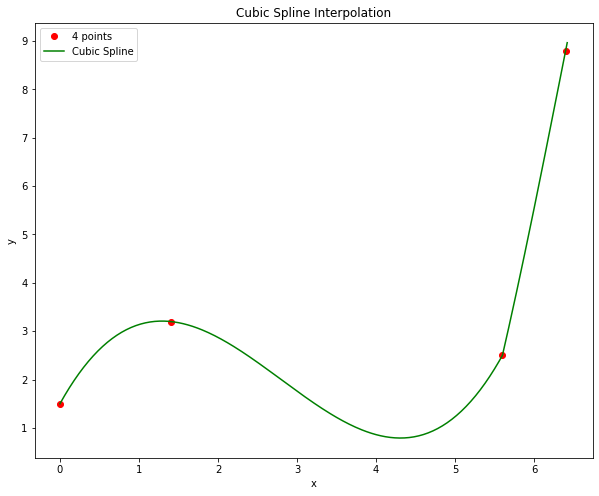

In [18]:
print("EX5")


def my_cubic_spline(x, y, X):
    """
    This is for four nodes (points) only x and y are the node and 
    X is the number of points to draw between the lines and must be
    in equal distances such that the distance between x1 and x2 is
    1 and the distance beween x2 and x3 is 3 then the points should
    be 3 times the number between x1 and x2.
    """
    n = len(x)
    # for four points only need to add to m equations or remove
    # some respectively depending on the number of points.
    num_equ = 4 * (n - 1)

    # Constraints Si(xi) = y(i)
    m1 = [x[0]**3, x[0]**2, x[0], 1, 0, 0, 0, 0, 0, 0, 0, 0]
    m2 = [0, 0, 0, 0, x[1]**3, x[1]**2, x[1], 1, 0, 0, 0, 0]
    m3 = [0, 0, 0, 0, 0, 0, 0, 0, x[2]**3, x[2]**2, x[2], 1]
    # Constraints Si(xi+1) = y(i+1)
    m4 = [x[1]**3, x[1]**2, x[1], 1, 0, 0, 0, 0, 0, 0, 0, 0]
    m5 = [0, 0, 0, 0, x[2]**3, x[2]**2, x[2], 1, 0, 0, 0, 0]
    m6 = [0, 0, 0, 0, 0, 0, 0, 0, x[3]**3, x[3]**2, x[3], 1]
    # First derivative S'(xi+1) = S'i+1(xi+1)
    m7 = [3*x[1]**2, 2*x[1], 1, 0, -3*x[1]**2, -2*x[1], -1, 0, 0, 0, 0, 0]
    m8 = [0, 0, 0, 0, 3*x[2]**2, 2*x[2], 0, 0, -0*x[2]**2, -0*x[2], -0, 0]  # S'(xi)=0
    m9 = [0, 2, 0, 0, 0, -2, 0, 0, 0, 0, 0, 0]  # a1 = a2 = 0 Endpoint Conditions
    #m9 = [6*x[0], 2, 0, 0, -6*x[0], -2, 0, 0, 0, 0, 0, 0]  # a1 = a2 Endpoint Conditions
    #m9 = [0, 0, 0, 0, 0, 0, 0, 0, 3*x[2]**2, 2*x[2], 1, 0]  # No Modified Conditions
    #m9 = [6*x[0], 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # Endpoint Conditions Natural
    # Second derivative S''(xi+1) = S''i+1(xi+1)
    m10 = [6*x[1], 2, 0, 0, -6*x[1], -2, 0, 0, 0, 0, 0, 0]
    m11 = [0, 0, 0, 0, 6*x[2], 2, 0, 0, -6*x[2], -2, 0, 0]
    m12 = [0, 0, 0, 0, 0, 0, 0, 0, 6*x[3], 2, 0, 0]
    m = [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12]

    # Create an empty matrix annd assign values to each point.
    M = np.zeros((num_equ, num_equ))
    for i in range(len(m)):
        M[i, :] = m[i]
    
    # This is the Y vector Ax=Y
    Y = [y[0], y[1], y[2], y[1], y[2], y[3], 0, 0, 0, 0, 0, 0]

    # Solve the sytem of equations
    coef = np.dot(np.linalg.inv(M), Y)
    # To get the spacing correct used differance between x values 
    # times 50 this give proper spacing to plot
    xdiff = np.diff(x)
    x_diff_sum = np.sum(np.diff(x))
    plot_points = 50 * x_diff_sum
   
    # Create the ranges for x values
    x_sp1 = np.arange(0, x[1], xdiff[0]/(xdiff[0]/x_diff_sum*plot_points))
    x_sp2 = np.arange(x[1], x[2], xdiff[1]/(xdiff[1]/x_diff_sum*plot_points))
    x_sp3 = np.arange(x[2], x[3]+ (xdiff[2]/(xdiff[2]/x_diff_sum*plot_points)),
                      (xdiff[2]/(xdiff[2]/x_diff_sum*plot_points)))

    # The equations for interpolated y value between nodes
    y_sp3 = coef[8]*x_sp3**3 + coef[9]*x_sp3**2 +  coef[10]*x_sp3 + coef[11]
    y_sp2 = coef[4]*x_sp2**3 + coef[5]*x_sp2**2 +  coef[6]*x_sp2 + coef[7]
    y_sp1 = coef[0]*x_sp1**3 + coef[1]*x_sp1**2 +  coef[2]*x_sp1 + coef[3]

    # Put them all togather
    Y = np.concatenate((y_sp1, y_sp2, y_sp3))

    return Y


x = [0, 1.4, 5.6, 6.4]
y = [1.5, 3.2, 2.5, 8.8]
x_diff_sum = np.sum(50*np.diff(x))
x_sp = np.arange(0, np.max(x) + (np.max(x)/x_diff_sum), (np.max(x)/x_diff_sum))
y_sp = my_cubic_spline(x, y, x_sp)

fig = plt.figure(figsize = (10,8))
plt.plot(x, y, 'ro', label=f"{len(x)} points")
plt.plot(x_sp, y_sp, 'g', label="Cubic Spline")
plt.title(f'Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


EX6
8 8


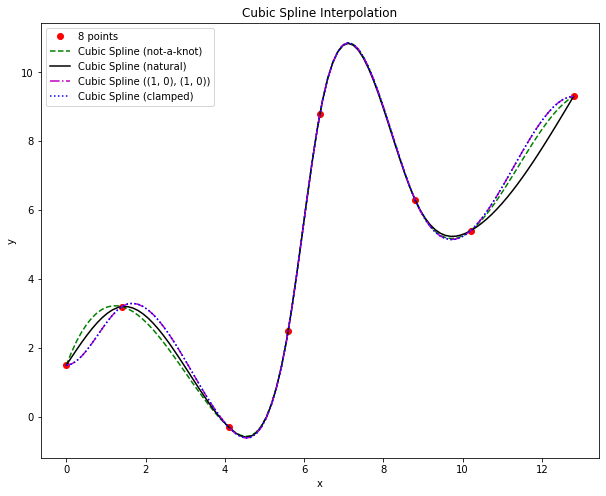

In [76]:
print("EX6")

x = [0, 1.4, 4.1, 5.6, 6.4, 8.8, 10.2, 12.8]
y = [1.5, 3.2, -.3, 2.5, 8.8, 6.3, 5.4, 9.3]

xs = np.linspace(min(x), max(x), 100)
bc = ((1, 0),(1, 0))
cs1 = CubicSpline(x, y, axis=1, bc_type='not-a-knot', extrapolate=True)
cs2 = CubicSpline(x, y, bc_type='natural')
cs3 = CubicSpline(x, y, bc_type=bc, extrapolate=True)
cs4 = CubicSpline(x, y, bc_type='clamped')

print(len(x), len(y))
fig = plt.figure(figsize = (10,8))
plt.plot(x, y, 'ro', label=f"{len(x)} points")
plt.plot(xs, cs1(xs), 'g--', label="Cubic Spline (not-a-knot)")
plt.plot(xs, cs2(xs), 'k-', label="Cubic Spline (natural)")
plt.plot(xs, cs3(xs), 'm-.', label=f"Cubic Spline {bc}")
plt.plot(xs, cs3(xs), 'b:', label="Cubic Spline (clamped)")
plt.title(f'Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [5]:
import matplotlib
[x for x in matplotlib.colors.ColorConverter.colors.keys() if len(x)==1]

['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

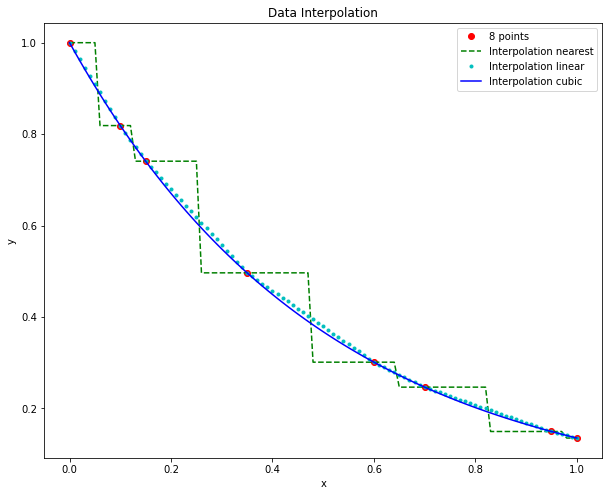

In [7]:
print('EX7')


def my_interp_plotter(x, y, X, option):
    f = interpolate.interp1d(x, y, kind=option)
    Y = f(X)
    return Y


# The question request spline interp1d is a spline method that uses
# linear, cubic, and nearest
x = np.array([0.0, 0.1, 0.15, 0.35, 0.6, 0.7, 0.95, 1.0])
y = np.array([1.0, 0.8187, 0.7408, 0.4966, 0.3012, 0.2466, 0.1496, 0.1353])
X_inp = np.linspace(0, 1, 101)

opt1 = 'nearest'
opt2 = 'linear'
opt3 = 'cubic'

Y_inp1 = my_interp_plotter(x, y, X_inp, opt1)
Y_inp2 = my_interp_plotter(x, y, X_inp, opt2)
Y_inp3 = my_interp_plotter(x, y, X_inp, opt3)

fig = plt.figure(figsize = (10,8))
plt.plot(x, y, 'ro', label=f"{len(x)} points")

plt.plot(X_inp, Y_inp1, 'g--', label=f"Interpolation {opt1}")
plt.plot(X_inp, Y_inp2, 'c.', label=f"Interpolation {opt2}")
plt.plot(X_inp, Y_inp3, 'b', label=f"Interpolation {opt3}")

plt.title(f'Data Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Select a Method number :
1: Cubic
2: Linear
3: Nearest
Method: 2
Selected Method: linear


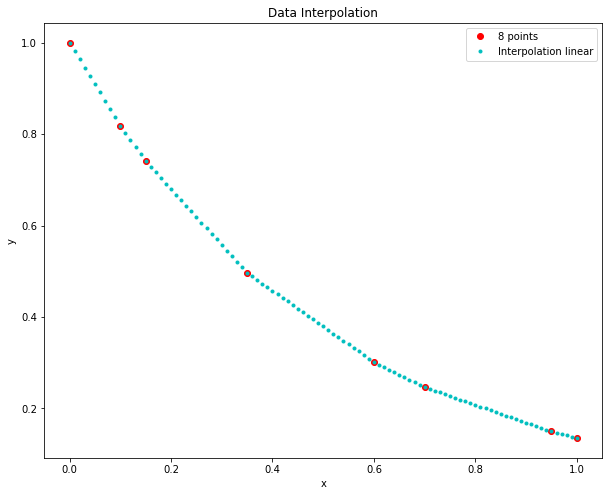

In [23]:

def select_items(options, name):
    """Allows the user to select the option"""

    index = 0
    indexValidList = []
    print(f'Select a {name} number :')
    for optionName in options:
        index = index + 1
        indexValidList.extend([options[optionName]])
        print(f'{str(index)}: {optionName}')
    inputValid = False
    while not inputValid:
        inputRaw = input(f'{name}: ')
        inputNo = int(inputRaw) - 1
        if inputNo > -1 and inputNo < len(indexValidList):
            selected = indexValidList[inputNo]
            print(f'Selected {name}: {selected}')
            inputValid = True
            break
        else:
            print(f'Please select a valid {name} {number}')

    return selected


def my_interp_plotter(x, y, X, option):
    f = interpolate.interp1d(x, y, kind=option)
    Y = f(X)
    return Y


method = {}
method["Cubic"] = 'cubic'
method["Linear"] = 'linear'
method["Nearest"] = 'nearest'

# Let user select a method
option = select_items(method, 'Method')

x = np.array([0.0, 0.1, 0.15, 0.35, 0.6, 0.7, 0.95, 1.0])
y = np.array([1.0, 0.8187, 0.7408, 0.4966, 0.3012, 0.2466, 0.1496, 0.1353])
X_inp = np.linspace(0, 1, 101)

Y_inp1 = my_interp_plotter(x, y, X_inp, option)

fig = plt.figure(figsize = (10,8))
plt.plot(x, y, 'ro', label=f"{len(x)} points")

if option == 'cubic':
    color = 'b-'
elif option == 'linear':
    color = 'c.'
else:
    color = 'g--'

    
plt.plot(X_inp, Y_inp1, color, label=f"Interpolation {option}")

plt.title(f'Data Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

0.54017857


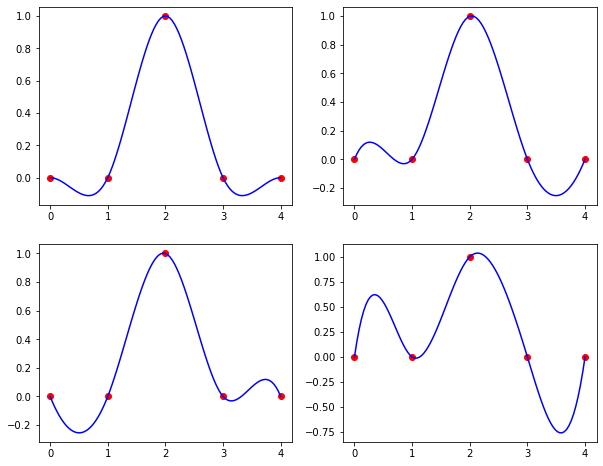

In [27]:
print('EX8')


def my_D_cubic_spline(x, y, X, D):
    bc = ((1, D),(1, D))
    f = CubicSpline(x, y, bc_type=bc)
    Y = f(X)
    return Y


# The question request spline interp1d is a spline method that uses
# linear, cubic, and nearest
x = np.array([0, 1, 2, 3, 4])
y = np.array([0, 0, 1, 0, 0])
X = np.linspace(0, 4, 101)

Y = np.round(my_D_cubic_spline(x, y, 1.5, 1),8)
print(Y)

plt.figure(figsize = (10,8))
plt.subplot(221)
plt.plot(x, y, 'ro', X, my_D_cubic_spline(x, y, X, 0), 'b')
plt.subplot(222)
plt.plot(x, y, 'ro', X, my_D_cubic_spline(x, y, X, 1), 'b')
plt.subplot(223)
plt.plot(x, y, 'ro', X, my_D_cubic_spline(x, y, X, -1), 'b')
plt.subplot(224)
plt.plot(x, y, 'ro', X, my_D_cubic_spline(x, y, X, 4), 'b')
plt.show()

EX9


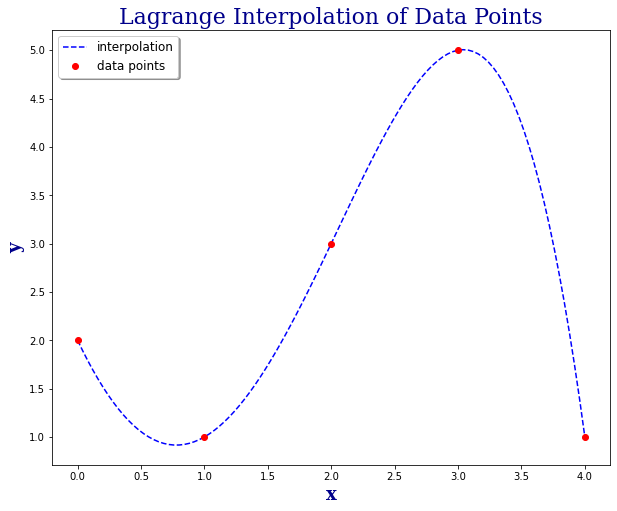

In [31]:
print('EX9')


def my_Lagrange(x, y, X):
    # Set interpolated value initially to zero
    n = len(x)
    yp = 0
    # Lagrange Interpolation Method
    for i in range(n):
        p = 1
        for j in range(n):
            if i != j:
                p = p * (X - x[j])/(x[i] - x[j])
        yp = yp + p * y[i]
    return yp


# Number of data points
x = [0, 1, 2, 3, 4]
y = [2, 1, 3, 5, 1]

Xp = np.linspace(0, 4, 101)

# Map fonts used in plot
font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 22,
        }

font2 = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'bold',
        'size': 18,
        }

plt.figure(figsize = (10,8))
plt.plot(Xp, my_Lagrange(x, y, Xp), 'b--', label='interpolation')
plt.plot(x, y, 'ro', label='data points')
plt.title(f'Lagrange Interpolation of Data Points', fontdict=font)
plt.xlabel('x', fontdict=font2)
plt.ylabel('y', fontdict=font2)
plt.legend(loc='upper left', shadow=True, fontsize=12, fancybox=True)
plt.show()


EX10
Taken From Book
The coefficient matrix
[[ 2.    -1.     1.5   -0.5   -0.125]
 [ 1.     2.     0.    -1.     0.   ]
 [ 3.     2.    -3.     0.     0.   ]
 [ 5.    -4.     0.     0.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]
coeffient array
 [2, -1.0, 1.5, -0.5, -0.125]
y values with divided diff matrix
 [2.        1.7414875 1.5168    1.3269875 1.1728    1.0546875 0.9728
 0.9269875 0.9168    0.9414875 1.        1.0909875 1.2128    1.3634875
 1.5408    1.7421875 1.9648    2.2054875 2.4608    2.7269875 3.
 3.2754875 3.5488    3.8149875 4.0688    4.3046875 4.5168    4.6989875
 4.8448    4.9474875 5.        4.9949875 4.9248    4.7814875 4.5568
 4.2421875 3.8288    3.3074875 2.6688    1.9029875 1.       ]
y values with divided diff array
 [2.        1.7414875 1.5168    1.3269875 1.1728    1.0546875 0.9728
 0.9269875 0.9168    0.9414875 1.        1.0909875 1.2128    1.3634875
 1.5408    1.7421875 1.9648    2.2054875 2.4608    2.7269875 3.
 3.2754875 3.5488    3.8149875 4.0688    4.

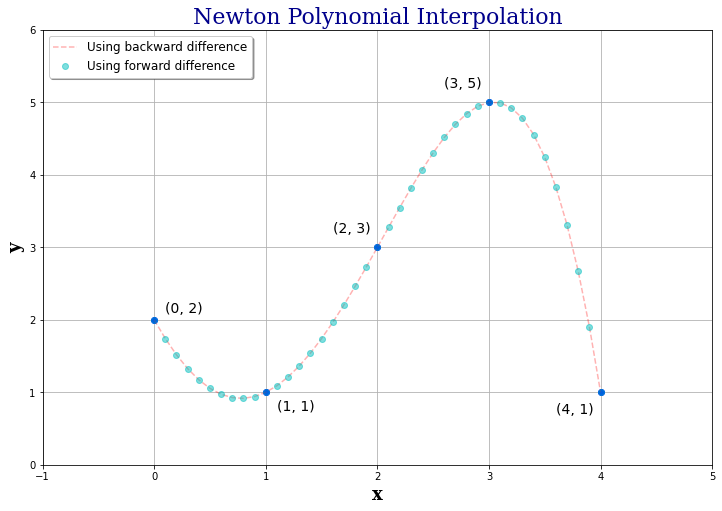

In [10]:
print('EX10')
print("Taken From Book")


def divided_diff(x, y):
    '''
    function to calculate the divided
    differences table
    '''
    n = len(y)  # Total number of values
    # Create a matrix of zeros size of n (4 x 4)
    # to write new values into.
    coef = np.zeros([n, n])
   
    # The first column is the y data values ([2, 1, 3, 5, 1])
    coef[:,0] = y

    # Create the divided differences table, coef table.
    # Based on f[x(k),x(k-1)...,x1, x0] = 
    # (f[xk,xk-1...x2,x2] - f[x(k-1), x(k-2)...,x1,x0])/(x(k) - x0)
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j]-x[i])
    print(f'The coefficient matrix\n{coef}')
    # returns a nxn matrix with coefficient list as top row or 
    # coef[0][4], coef[0][3], coef[0][2], coef[0][1]
    return coef  


def newt_div_diff(x, y):
    '''x : array of data points
       y : array of f(x)  '''
    # x.astype(float)
    # y.astype(float)
    n = len(x)
    c = []
    for i in range(n):
        c.append(y[i])
        # creates an array of the y values
    for j in range(1, n):
        # starting from the last value
        for i in range(n-1, j-1, -1):
            c[i] = float(c[i]-c[i-1])/float(x[i]-x[i-j])
            # using an array to build the coefficient list
    print(f'coeffient array\n {c}')
    return np.array(c) # return an array of coefficient


def newton_poly(coef, x_data, x):
    '''
    evaluate the newton polynomial 
    at x
    The coef is returned from divided_diff(x, y);
    The x_data is the actual x data array;
    The x is a series of numbers from 
    minimum x value (0) to maximum x value (4)
    in small segments (0.1). This creates a 
    new series of y values to plot through the points.
    '''
    n = len(x_data) - 1 
    p = coef[n]
    
    for k in range(1,n+1):
        p = coef[n - k] + (x - x_data[n - k])*p

    return p


# Arrays for x and y 
x = np.array([0, 1, 2, 3, 4])
y = np.array([2, 1, 3, 5, 1])


# get the divided difference coef
a_s = divided_diff(x, y)[0, :] 
coff = newt_div_diff(x, y)

# evaluate on new data points
x_new = np.arange(0, 4.1, .1)
y_new = newton_poly(a_s, x, x_new)
print(f'y values with divided diff matrix\n {y_new}')
dif_y = newton_poly(coff, x, x_new)
print(f'y values with divided diff array\n {dif_y}')
# font dictonary
font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 22,
        }

font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 18,
        }

plt.figure(figsize = (12, 8))
plt.plot(x, y, 'bo')
plt.plot(x_new, dif_y, 'r--', alpha=0.3, label='Using backward difference')
plt.plot(x_new, y_new, 'co', alpha=0.5, label='Using forward difference')
plt.title('Newton Polynomial Interpolation', fontdict=font)
plt.annotate('(0, 2)', xy=(0, 2), xytext=(0.1, 2.1), fontsize=14)
plt.annotate('(1, 1)', xy=(1, 1), xytext=(1.1, .75), fontsize=14)
plt.annotate('(2, 3)', xy=(2, 3), xytext=(1.6, 3.2), fontsize=14)
plt.annotate('(3, 5)', xy=(3, 5), xytext=(2.6, 5.2), fontsize=14)
plt.annotate('(4, 1)', xy=(4, 1), xytext=(3.6, .7), fontsize=14)
plt.grid()
plt.xlim(-1, 5)
plt.ylim(0, 6)
plt.xlabel('x', fontdict=font2)
plt.ylabel('y', fontdict=font2)
legend = plt.legend(loc='upper left', shadow=True, fontsize=12, fancybox=True)
plt.show()